In [ ]:
import pyarrow.parquet as pq
import numpy as np

import tifffile as tiff
import matplotlib.pyplot as plt

In [ ]:
filename = "/system/user/publicwork/sanchez/datasets/jumpcp-indices/indices/source_3_filtered_good_batches.pq"

table = pq.read_table(filename).to_pandas()

#print(table.iloc[0])
print("Labels:")
print(table["Metadata_JCP2022"].value_counts())
print("Meta-Batches:")
print(table["Metadata_Batch"].value_counts())

label_counts_per_batch = (
    table
    .groupby("Metadata_Batch")["Metadata_JCP2022"]
    .value_counts()
)

#print(label_counts_per_batch.to_string())
#in subset 8 unique comnpounds
#['JCP2022_085227' 'JCP2022_035095' 'JCP2022_037716' 'JCP2022_064022' 'JCP2022_025848' 'JCP2022_050797' 'JCP2022_046054' 'JCP2022_012818']
#classes are spread out evenly

In [ ]:
imges = tiff.imread('/system/user/publicdata/jumpcp/source_3_CP_35_all_Phenix1_BAY5871d_N08_2.jpg')
imges = np.transpose(imges, (2,0,1))

colors = [
(1.0, 0.0, 0.0),        # red
(1.0, 0.65, 0.0),       # orange
(0.7, 1.0, 0.0),        # yellow-green
(0.0, 1.0, 0.0),        # green
(0.0, 1.0, 1.0),        # cyan
]
titles = ["Mito", "AGP", "RNA", "ER", "DNA", "Combination"]

final = []

fig, axs = plt.subplots(2, 3, figsize=(15,10))
for i in range(5):
    img = imges[i,:,:].astype(np.float32) / 255.0
    print(img.shape)
    r,g,b = colors[i]
    img = np.stack([img*r,img*g,img*b], axis=-1)
    final.append(img)

    axs[i//3, i%3].imshow(img, cmap="gray")
    axs[i//3,i%3].axis("off")
    axs[i//3, i%3].set_title(titles[i], fontsize=20)
    
final = sum(final)
final = final/np.max(final)
axs[-1,-1].imshow(final, cmap="gray")
axs[-1,-1].axis("off")
axs[-1, -1].set_title(titles[-1], fontsize=20)

plt.tight_layout()
plt.savefig("cells.jpg")
plt.show()


In [ ]:
import sys
import os

src_path = os.path.split(os.getcwd())[0]
sys.path.insert(0, src_path)

from training.augmentations import autocontrast, equalize, posterize, int_parameter, sample_level, rotate, solarize, shear_x, shear_y, translate_x, translate_y
import torch
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from torchvision.transforms import AugMix

imges = tiff.imread('/system/user/publicdata/jumpcp/source_3_CP_35_all_Phenix1_BAY5871d_N08_2.jpg')
imges = np.transpose(imges, (2,0,1))
imges = torch.tensor(imges) /255.0


aug_img = solarize(imges, 3).numpy()
fig, axs = plt.subplots(2, 3)
for i in range(5):
    img = imges.numpy()[i,:,:].astype(np.float32) / 255.0

    axs[i//3, i%3].imshow(img, cmap="gray")
    axs[i//3,i%3].axis("off")
    

plt.tight_layout()
plt.show()
fig, axs = plt.subplots(2, 3)
for i in range(5):
    img = aug_img[i,:,:].astype(np.float32) / 255.0

    axs[i//3, i%3].imshow(img, cmap="gray")
    axs[i//3,i%3].axis("off")
    

plt.tight_layout()
plt.show()


In [18]:
import sys
import os

src_path = os.path.split(os.getcwd())[0]
sys.path.insert(0, src_path)
from training.data import JUMPCPDataset, transform_function, CustomSubset

from collections import defaultdict
from tqdm import tqdm
import numpy as np

test_file = "/system/user/publicwork/sanchez/datasets/jumpcp-indices/indices/source_3_filtered_good_batches.pq"
mapping = "/system/user/studentwork/seibezed/bachelor/data/class_mapping.json"
img_path = "/system/user/publicdata/jumpcp/"

values = defaultdict(list)

nums = np.random.randint(0, 49490, size=9000)
transforms = transform_function(n_px_tr=540, n_px_val=540, is_train=False, preprocess="crop", normalize=None)
dataset = JUMPCPDataset(test_file, img_path, mapping,transforms)
#dataset = CustomSubset(dataset,nums)

for img, label, _,metadata in tqdm(dataset):
    m = metadata["batch"]
    intensity = img.mean().item()
    values[m].append(intensity)



100%|██████████| 49491/49491 [34:22<00:00, 24.00it/s] 


KeyError: 49491

In [ ]:
import matplotlib.pyplot as plt

for key, value in values.items():
    print(key)
    plt.hist(value, bins=20,density=True, color='skyblue', edgecolor='black')
    plt.show()

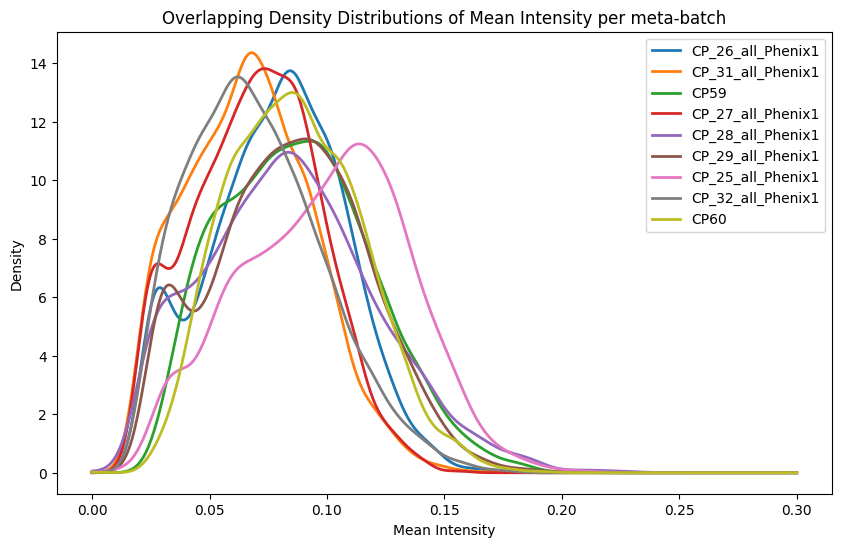

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

plt.figure(figsize=(10, 6))

# Shared x-axis for all distributions
x_min = min(map(min, values.values()))
x_max = max(map(max, values.values()))
x_max=0.3
x_grid = np.linspace(x_min, x_max, 500)

for key, value in values.items():
    kde = gaussian_kde(value)
    plt.plot(x_grid, kde(x_grid), linewidth=2, label=key)

plt.xlabel("Mean Intensity")
plt.ylabel("Density")
plt.title("Overlapping Density Distributions of Mean Intensity per meta-batch")
plt.legend()
plt.savefig("densities.png")
plt.show()